In [36]:
%matplotlib inline
import itertools

In [484]:
n_teams = 10
teams = ['T{}'.format(i) for i in range(n_teams)]
days = ['09-01', '09-02', '09-03']
years = [2010, 2011, 2012, 2013, 2014]

import random
teams = set(['T{}'.format(i) for i in range(10)])
matchups = []
for t in teams:
    opp = list(teams - set([t]))
    opp = random.sample(opp, int(len(opp) * .5))
    for o in opp:
        matchups.append('-'.join(sorted((t, o))))
matchups = np.unique(sorted(matchups))

data = []
for m in matchups:
    t1, t2 = m.split('-')[0], m.split('-')[1]
    t1i = int(t1.replace('T', ''))
    t2i = int(t2.replace('T', ''))
    for d in days:
        for y in years:
            mu_start = n_teams * 10 
            v1 = np.random.normal(loc=mu_start + (t1i - t2i)*10, scale=8, size=1)[0]
            v2 = np.random.normal(loc=mu_start + (t2i - t1i)*10, scale=8, size=1)[0]
            date = '{}-{}'.format(y, d)
            data.append([t1, t2, date, y, v1])
            data.append([t2, t1, date, y, v2])
data = pd.DataFrame(data, columns=['Team1', 'Team2', 'Date', 'Year', 'Value'])
data.head()

,Team1,Team2,Date,Year,Value
0,T0,T1,2010-09-01,2010,100.648172
1,T1,T0,2010-09-01,2010,109.557627
2,T0,T1,2011-09-01,2011,84.548691
3,T1,T0,2011-09-01,2011,116.502620
4,T0,T1,2012-09-01,2012,81.679652


In [490]:
data.groupby('Team2')['Value'].mean().order()

Team2
T9     44.002812
T8     55.816418
T7     74.543587
T6     83.175435
T5     95.320923
T4    110.554115
T3    120.393798
T2    144.316004
T1    149.050012
T0    153.676824
Name: Value, dtype: float64

In [478]:
import imp
imp.reload(scoring)

<module 'sports_math.scoring' from '/Users/eczech/repos/portfolio/functional/sports/python/sports_math/scoring.py'>

88.2898131724 88.4916777738


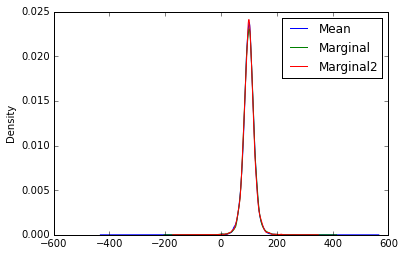

In [357]:
from scipy import stats
from sports_math import scoring

psamp = [100, 95, 100, 103, 98, 110, 90]
samp = [50, 100, 150]

M0, L0, A0, B0 = scoring.ngamma_posterior(samp, psamp)
#print(M0, L0, A0, B0)

params = scoring.rngamma(M0, L0, A0, B0, 10000)

plt.figure()
params['Marginal'] = np.random.standard_t(2*A0, size=10000) * TS + M0
params['Marginal2'] = stats.t(2*A0, loc=M0, scale=TS).rvs(10000)
p25 = scoring.ngamma_marginal_mu_ppf(M0, L0, A0, B0, [.25])
print(p25.iloc[0], np.percentile(params['Mean'], 25))
params[['Mean', 'Marginal', 'Marginal2']].plot(kind='kde')

In [491]:
def get_scores(d, year, date, season_threshold=3):
    d = d[d['Date'] <= date]
    prior_d = d[d['Year'] < year - season_threshold]['Value']
    curr_d = d[d['Year'] >= year - season_threshold]
    print(len(curr_d), len(prior_d))
    def get_team_scores(x):
        def get_opp_scores(y):
            raw_v = y['Value']
            w = np.array([year - y_past for y_past in y['Year']])
            w = np.max(w) - w + 1
            rep_v = []
            for i in range(len(raw_v)):
                #rep_v.extend(np.repeat(raw_v.iloc[i], 1))
                rep_v.extend(np.repeat(raw_v.iloc[i], w[i]))
            #print(y, rep_v)
            M0, L0, A0, B0 = scoring.ngamma_posterior(rep_v, prior_d)
            score = scoring.ngamma_marginal_mu_ppf(M0, L0, A0, B0, [.25]).iloc[0]
            #print(np.mean(raw_v), score)
            return score
        return x.groupby('Team2').apply(get_opp_scores)
    res = curr_d.groupby('Team1').apply(get_team_scores)
    res.name = 'Score'
    return res

In [492]:
scores = get_scores(data, 2014, '2014-09-02').reset_index()
scores.head()

748 204


,Team1,Team2,Score
0,T0,T1,92.072739
1,T0,T3,70.734240
2,T0,T4,62.898048
3,T0,T6,42.943141
4,T0,T7,31.971284


In [493]:
from sports_math import markov_chain_rank as mc_rank
ranks = mc_rank.get_ranks(scoring.get_normalized_scores(scores, linear=True))
ranks

Team2
T0    0.095849
T1    0.084349
T2    0.072554
T3    0.085638
T4    0.101213
T5    0.087577
T6    0.134319
T7    0.122050
T8    0.122542
T9    0.093909
dtype: float64

In [494]:
from sports_math import markov_chain_rank as mc_rank
ranks = mc_rank.get_ranks(scoring.get_normalized_scores(scores, linear=False))
ranks

Team2
T0    0.018018
T1    0.023387
T2    0.027823
T3    0.037347
T4    0.071071
T5    0.074182
T6    0.156461
T7    0.231724
T8    0.172468
T9    0.187521
dtype: float64